# Einstein-Rosen bridge

This Jupyter/SageMath notebook is relative to the tesis 
[Algunos estudios analíticos sobre la
geometría de Schwarzschild].

The involved computations make use of tools developed through the [SageManifolds project](https://sagemanifolds.obspm.fr).

*NB:* a version of SageMath at least equal to 7.5 is required to run this notebook: 

In [1]:
version()

'SageMath version 9.3, Release Date: 2021-05-09'

First we set up the notebook to display mathematical objects using LaTeX formatting:

In [2]:
%display latex

The rescaled Lambert function:

In [3]:
W0(x) = lambert_w(x/RDF(e)) + 1 

The minimal value of the Kruskal-Szekeres coordinate $X$ on a hypersurface $T=\mathrm{const}$:

In [4]:
def Xmin(T):
    return sqrt(max(0, RDF(T^2-1)))

Plot of $r$ as a function of $X$ on a hypersurface $T=T_0$:

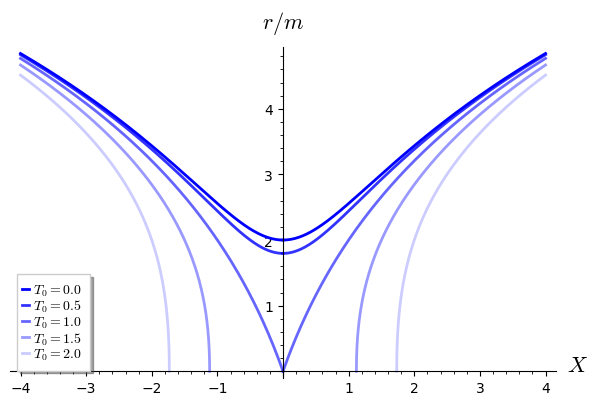

In [5]:
T0_list = [0., 0.5, 1., 1.5, 2.0001]
g = Graphics()
for T0 in T0_list:
    alp = 0.2 + 0.4*(2. - T0)
    g += plot(2*W0(x^2-T0^2), (x,-4,-Xmin(T0)), thickness=2, color='blue', alpha=alp,
              legend_label="$T_0={:02.1f}$".format(float(T0))) + \
         plot(2*W0(x^2-T0^2), (x, Xmin(T0), 4), thickness=2, color='blue', alpha=alp)
g.save("max_SigmaT0_r_X.png", aspect_ratio=1, axes_labels=[r'$X$', r'$r/m$'])
show(g, aspect_ratio=1, axes_labels=[r'$X$', r'$r/m$'])

### Plot of hypersurfaces $T=T_0$ in the Kruskal diagram

We generate first plots for the curvature singularity and the bifurcate horizon:

In [6]:
sing = plot(sqrt(1+x^2), (x,-3,3), color='brown', thickness=4, linestyle='--') \
       + text(r"$r=0$", (2.5, 3), rotation=45, fontsize=16, color='brown') \
       + plot(-sqrt(1+x^2), (x,-3,3), color='brown', thickness=4, linestyle='--') \
       + text(r"$r'=0$", (2.5, -3), rotation=-45, fontsize=16, color='brown')
bifhor = line([(-3,-3), (3,3)], color='black', thickness=3) + \
         line([(-3,3), (3,-3)], color='black', thickness=3) + \
         text(r'$\mathscr{H}$', (3, 2.7), fontsize=20, color='black')

We add the inner limits of the isometring embeddings for $|T_0|>1$: 

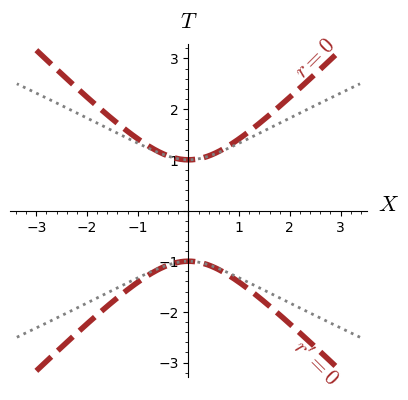

In [7]:
graph = sing
var('T')
Xemb(T) = abs(T)*sqrt(2*ln(abs(T)))
graph += parametric_plot([Xemb(T), T], (T, 1.001, 2.5), color='grey', thickness=2, linestyle=':') \
         + parametric_plot([-Xemb(T), T], (T, 1.001, 2.5), color='grey', thickness=2, linestyle=':') \
         + parametric_plot([Xemb(T), T], (T, -2.5, - 1.001), color='grey', thickness=2, linestyle=':') \
         + parametric_plot([-Xemb(T), T], (T, -2.5, - 1.001), color='grey', thickness=2, linestyle=':')
show(graph, aspect_ratio=1, axes_labels=[r'$X$', r'$T$'])

The minimal value of the Kruskal-Szekeres coordinate $X$ on an embedded surface of constant $T$:

In [8]:
def Xmin_emb(T):
    if abs(T) > 1:
        return Xemb(T)
    return 0

The plot of the hypersurfaces $T=T_0$ for selected values of $T_0$:

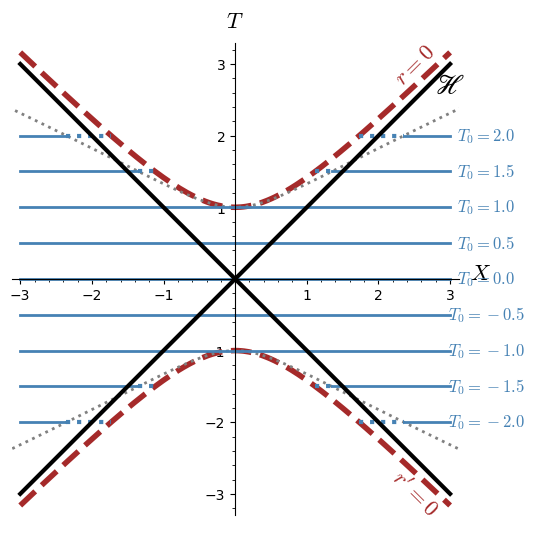

In [9]:
colorS = 'steelblue'
colorS3 = 'lightsteelblue'
#colorS = 'lightseagreen'
#colorS = 'wheat'
T0_list = [-2., -1.5, -1., -0.5, 0., 0.5, 1., 1.5, 2.0001]
for T0 in T0_list:
    graph += line([(-3, T0), (-Xmin_emb(T0), T0)], color=colorS, thickness=2) \
             + line([(-Xmin_emb(T0), T0), (-Xmin(T0), T0)], color=colorS, 
                    thickness=3, linestyle=':') \
             + line([(Xmin(T0), T0), (Xmin_emb(T0), T0)], color=colorS, 
                    thickness=3, linestyle=':') \
             + line([(Xmin_emb(T0), T0), (3, T0)], color=colorS, thickness=2) \
             + text("$T_0={:02.1f}$".format(float(T0)), (3.5, T0), 
                    fontsize=12, color=colorS)
graph += bifhor
graph.save('max_constant_T_slices.png', aspect_ratio=1, 
           xmin=-3, xmax=3, axes_labels=[r'$X$', r'$T$'], figsize=8)
show(graph, aspect_ratio=1, xmin=-3, xmax=3, axes_labels=[r'$X$', r'$T$'], figsize=8)

## Isometric embeddings

The function $Z'(r)$: 

In [10]:
var('r')
zp(r,T) = sqrt((1-T^2*e^(-r/2))/(r/2-1+T^2*e^(-r/2)))
zp

(r, T) |--> sqrt(2)*sqrt(-(T^2*e^(-1/2*r) - 1)/(2*T^2*e^(-1/2*r) + r - 2))

The exact integral is not known in the general case:

In [11]:
z = integrate(zp(r,T), r)
z

sqrt(2)*integrate(sqrt(-(T^2*e^(-1/2*r) - 1)/(2*T^2*e^(-1/2*r) + r - 2)), r)

The minimal value of $r$ on an embedded surface of constant $T$:

In [12]:
def rmin(T):
    if T > 1:
        return RDF(4*ln(T))
    return 2*W0(-T^2)

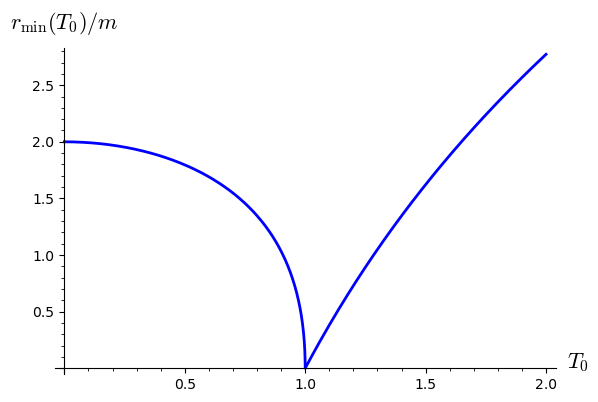

In [13]:
plot(rmin, (T,0,2), axes_labels=[r'$T_0$', r'$r_{\rm min}(T_0)/m$'], thickness=2)

In [14]:
rmin(1/2), rmin(3/2)

(1.796343137811716, 1.6218604324326575)

The integration of $Z'(r)$ to get $Z(r)$ is performed numerically, using an algorithm for an adaptive integration with (integrable) singularities (`qags`):

In [15]:
def zz(r1, T0):
    dzdr = zp(r, T0)
    numint = numerical_integral(dzdr, rmin(T0), r1, algorithm='qags')
    error = numint[1]
    if error > 1e-3: 
        print("Warning: error = {}".format(error))
    if T0 > 1:
        return numint[0] + 1
    return numint[0]

Test that it works:

In [16]:
zz(4, 1/2), zz(4, 3/2)

(4.226847171416414, 2.4583755881988343)

Function $Z(r)$ for some selected values of $T_0$:

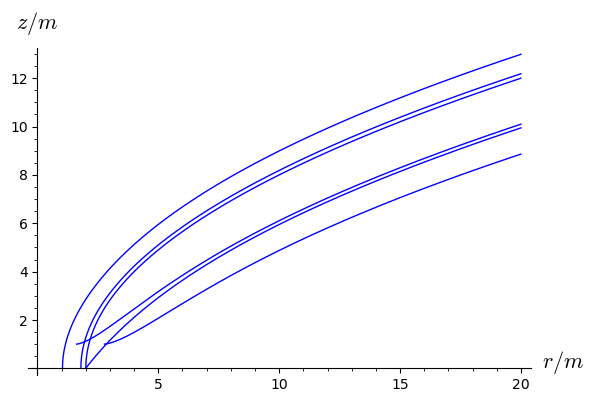

In [17]:
T0_list = [0., 0.5, 0.9, 1., 1.5, 2.]
g = Graphics()
for T0 in T0_list:
    g += plot(lambda r: zz(r, T0), rmin(T0), 20)
show(g, aspect_ratio=1, xmin=0, xmax=20, axes_labels=[r'$r/m$', r'$z/m$'])

### 3D plots of the embeddings

In [18]:
var('ph', latex_name=r'\phi', domain='real')

ph

In [19]:
from sage.manifolds.utilities import set_axes_labels

In [ ]:
T0_list = [0., 0.5, 0.9, 1., 1.5, 2.]
rmax = 8 # in units of m
for T0 in T0_list:
    g1 = parametric_plot3d([lambda r,ph: r*cos(ph), lambda r,ph: r*sin(ph), 
                            lambda r,ph: zz(r, T0)], 
                           (rmin(T0), rmax), (0, 2*pi), color=colorS3)
    g2 = parametric_plot3d([lambda r,ph: r*cos(ph), lambda r,ph: r*sin(ph), 
                            lambda r,ph: -zz(r, T0)], 
                           (rmin(T0), rmax), (0, 2*pi), color=colorS3)
    g = set_axes_labels(g1 + g2, 'x', 'y', 'z')
    print("T_0 = {:02.1f}".format(float(T0)))
    show(g, aspect_ratio=1)
    # show(g, aspect_ratio=1, viewer='tachyon', frame=False, figsize=20)
    g.save_image("max_embedding_T0_{:02.1f}.png".format(float(T0)), aspect_ratio=1, 
                 figsize=10, viewer='jmol')

T_0 = 0.0


Graphics3d Object

T_0 = 0.5


Graphics3d Object

T_0 = 0.9


Graphics3d Object

T_0 = 1.0


Graphics3d Object

T_0 = 1.5


Graphics3d Object

Zoom out of the $T_0=0$ surface (Flamm paraboloid):

In [ ]:
T0 = 0
rmax = 50 # in units of m
g1 = parametric_plot3d([lambda r,ph: r*cos(ph), lambda r,ph: r*sin(ph), 
                            lambda r,ph: zz(r, T0)], 
                           (rmin(T0), rmax), (0, 2*pi), color=colorS3)
g2 = parametric_plot3d([lambda r,ph: r*cos(ph), lambda r,ph: r*sin(ph), 
                            lambda r,ph: -zz(r, T0)], 
                           (rmin(T0), rmax), (0, 2*pi), color=colorS3)
g = set_axes_labels(g1 + g2, 'x', 'y', 'z')
print("T_0 = {:02.1f}".format(float(T0)))
show(g, aspect_ratio=1)

In [ ]:
g.save_image("max_flamm_paraboloid_far.png", aspect_ratio=1, figsize=10, 
             viewer='jmol')